# Quantum Alternating Operator Ansatz for Two-Color Multi Car Paint Shop Optimization
The goal of the multi-car paint shop optimization is to reduce the number of color switches between cars in a paint shop line during the manufacturing process, which is recognized as an NP-hard problem.

Let's consider two-color scenario in this tutorial.  

In [1]:
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import openjij as oj
import qamomile as qm
import numpy as np
import random as rand

## Formulation using JijModeling
Let's first model the problem using JijModeling.

In [2]:
def get_mcps_problem() -> jm.Problem:
  V = jm.Placeholder("V", ndim=2) # sequence of car entry
  W = jm.Placeholder("W", ndim=1) # number of black cars by model
  N = jm.Placeholder("N") # number of cars
  M = jm.Placeholder("M") # number of car models
  x = jm.BinaryVar("x", shape=(N,))
  i = jm.Element("i", belong_to=(0, N-1))
  j = jm.Element("j", belong_to=(0, N))
  e = jm.Element("e", belong_to=(0, 2))
  m = jm.Element("m", belong_to=(0, M))

  problem = jm.Problem("MCPS", sense=jm.ProblemSense.MAXIMIZE)
  problem += jm.sum([i], (x[i] - 0.5) * (x[i+1] - 0.5))
  problem += jm.Constraint("n-hot", jm.sum([j], V[j][m] * x[j]) == W[m], forall=m)
  return problem
problem = get_mcps_problem()
problem

In [3]:
number_of_models = 4 
number_of_cars = 8
# number of black cars by model
black_per_models = [1, 1, 1, 1]

# Create 8 cars in 4 different kinds of models
cars = [0, 0, 1, 1, 2, 2, 3, 3] 
rand.shuffle(cars)
print(f"The order of car intake: {cars}") 

#Create a 2d array of the sequence of car entry
cars_onehot = np.eye(number_of_models)[cars]
print(cars_onehot)

The order of car intake: [3, 3, 1, 0, 0, 1, 2, 2]
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


## Creating a Compiled Instance
A compiled instance is an intermediate representation where actual values are substituted into the constants of the mathematical expressions. Before converting to various algorithms, it is necessary to first create this compiled instance.

In [4]:
data = {"V": cars_onehot, "W":  black_per_models, "N":  number_of_cars, "M": number_of_models}
compiled_model = jmt.compile_model(problem, data)

## Generation of QAOA Circuit and Hamiltonian Using Qamomile
Qamomile provides a converter that generates circuits and Hamiltonians for QAOA from the compiled instance. Additionally, it allows setting parameters that arise during the conversion to QUBO.

First, we will generate the Ising Hamiltonian. Once this is done, we can also generate the quantum circuit and Hamiltonian for QAOA. 

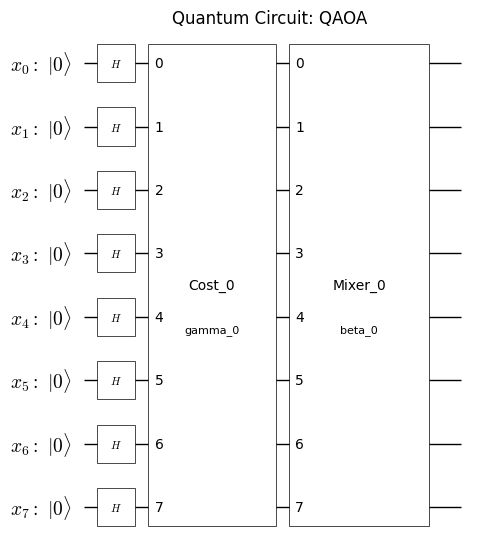

In [5]:
from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.core.circuit.drawer import plot_quantum_circuit

qaoa_converter = QAOAConverter(compiled_model)
# Encode to Ising Hamiltonian
qaoa_converter.ising_encode(multipliers={"n-hot": 3})
# Get the QAOA circuit
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=1)
plot_quantum_circuit(qaoa_circuit) #print it out
# Get the cost Hamiltonian
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

## Converting the Obtained Circuit and Hamiltonian for Qiskit
let's first convert the circuit and Hamiltonian for Qiskit.

In [6]:
import qamomile.qiskit as qm_qk
qk_transpiler = qm_qk.QiskitTranspiler()

# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_cost)

## Running QAOA
Now that everything is ready, let's run QAOA. Here, we are using Scipy's COBYLA as the optimization algorithm.

In [7]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

# Run QAOA optimization
result = minimize(
    cost_estimator,
    np.random.rand(2) * np.pi,
    method="COBYLA",
    options={"maxiter": 100},
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.3619193086650094
       x: [ 2.749e+00  1.538e+00]
    nfev: 71
   maxcv: 0.0


Let's also take a look at the changes in the cost function

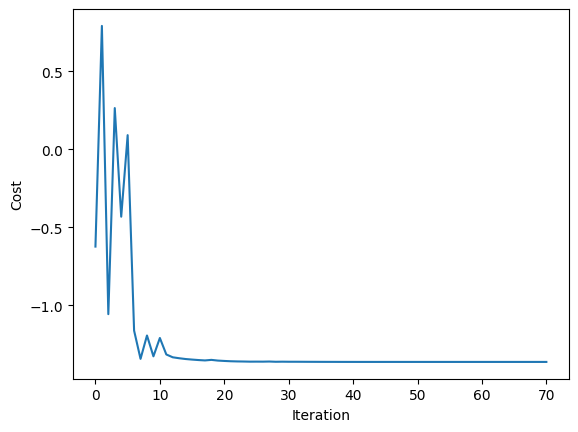

In [8]:
import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Now we have obtained the QAOA parameters. Let's use them for sampling

In [9]:
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

## Evaluating the Results

In [10]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])
max_energy = -1e9
best_values = None
for sample in sampleset.feasibles():
    if max_energy < sample.eval.objective:
        max_energy = sample.eval.objective
        best_values = sample.var_values

best_values = sampleset.lowest()[0].var_values

values = [0] * 8
for idx in best_values["x"].values:
  values[idx[0]] = 1

print("The order of car intake: ", cars)
print("Color separation: ", values)

The order of car intake:  [3, 3, 1, 0, 0, 1, 2, 2]
Color separation:  [1, 0, 1, 0, 1, 0, 1, 0]


## Evaluation using classical algorithms
Comparing the best costs by searching through all feasible solutions

In [20]:
def eval_mcps_state(cars, black_per_models, state, num_cars, num_models):
  cnt = [0] * num_models
  for i in range(num_cars):
    cnt[cars[i]] += state[i]
  for i in range(num_models):
    if black_per_models[i] != cnt[i]:
      return None
  score = 0
  for i in range(num_cars-1):
    if state[i] != state[i+1]:
      score += 1
  return score

def best_cost_mcps(cars, black_per_models, num_cars, num_models):
  best_score = 1e9
  for i in range(2**num_cars):
    state = [0] * num_cars
    for j in range(num_cars):
      if i & (2**j) != 0:
        state[j] = 1
    score = eval_mcps_state(cars, black_per_models, state, num_cars, num_models)
    if not(score is None):
      best_score = min(best_score, score)
  return best_score

exact_score = best_cost_mcps(cars, black_per_models, number_of_cars, number_of_models)
qaoa_score = eval_mcps_state(cars, black_per_models, values, number_of_cars, number_of_models)
print("exact solution: ", exact_score)
print("solution using QAOA: ", qaoa_score)

exact solution:  3
solution using QAOA:  7
